# Electron MVA Tutorial

Hello, good to see you again! This is the main part of the tutorial, where we inspect and understand the ntuples a bit, before finally training a few BTDs to separate real prompt electrons from fakes.

## Prerequesites

### Install Python packages

We need to install two additional Python packages to run this notebook:

* [uproot](https://github.com/scikit-hep/uproot) to open ROOT files
* [tqdm](https://github.com/tqdm/tqdm) to draw progessbars

The other packages we rely on, in particular [xgboost](https://xgboost.readthedocs.io/en/latest/) for training BDTs, [pandas](https://pandas.pydata.org/) and [sklearn](https://scikit-learn.org/stable/index.html) are already installed in the SWAN environment.

You can execute bash commands withing the notebook by putting an exclamation mark `!` in front of them. You can uncomment the following cell and run it to invoke `pip` to install the missing packages:

In [1]:
#!pip install --user uproot tqdm

After the installations are finished, you have to restart the notebook kernel with the little circular arrow button in the toolbar above. You may now comment out the pip command again so it's not always run when you execute all cells in this notebook.

### Login with you CERN account to get Ntuples from EOS

In the first part of this tutorial, we showed you how to create the Electron MVA ntuples and you produced them yourself for one ROOT file. One file is unfortunately not enough for training the MVA.

We processed the whole Run 3 __DY+Jets__ MC sample for you and put the ROOT files into the EOS user space. To access them, please login to EOS by running the cells below (don't forget to change the username to yours):

In [2]:
username = "rembserj"

········


## Electron MVA Ntuple Data

Let's import __uproot__ to open ROOT files, __glob__ to  search for files, __pandas__ for DataFrames and __tqdm__ for progress bars.

In [4]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm

We need a lot of events to train the Electron MVA well, but using the full dataset would take too long in this tutorial. Let's just get the names of __10 files__.

In [5]:
n_files = 20
root_files = glob.glob("/eos/user/r/rembserj/ntuples/electron_mva_run3/*.root")[:n_files]

In [6]:
f = uproot.open(root_files[0])
f.allkeys()

['ntuplizer;1', 'ntuplizer/tree;1']

There we go, the TTree with the electron data we seek must be `ntuplizer/tree`!

With that knowledge we can write a function that takes the path to a Electron MVA Ntuple file and returns a DataFrame with all the data except for some columns we won't use.

In [7]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

def get_df(root_file_name):
    f = uproot.open(root_file_name)
    if len(f.allkeys()) == 0:
        return pd.DataFrame()
    df = uproot.open(root_file_name)["ntuplizer/tree"].pandas.df()
    return df.drop(unneccesary_columns, axis=1)

Let's use this function in a loop to load all files and combine the DataFrames with `pandas.concat`:

In [8]:
df = pd.concat((get_df(f) for f in  tqdm(root_files)), ignore_index=True)

100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


We can check what columns we have in this data (or "branches" if you come from ROOT):

In [9]:
df.columns

Index([u'genNpu', u'vtxN', u'ele_q', u'ele_3q', u'matchedToGenEle', u'rho',
       u'ele_pt', u'ele_oldsigmaietaieta', u'ele_oldsigmaiphiiphi',
       u'ele_oldcircularity', u'ele_oldr9', u'ele_scletawidth',
       u'ele_sclphiwidth', u'ele_hadronicOverEm', u'ele_oldhe', u'ele_kfhits',
       u'ele_kfchi2', u'ele_gsfchi2', u'ele_fbrem', u'ele_gsfhits',
       u'ele_expected_inner_hits', u'ele_conversionVertexFitProbability',
       u'ele_ep', u'ele_eelepout', u'ele_IoEmIop', u'ele_deltaetain',
       u'ele_deltaphiin', u'ele_deltaetaseed', u'ele_psEoverEraw',
       u'ele_pfPhotonIso', u'ele_pfChargedHadIso', u'ele_pfNeutralHadIso',
       u'scl_E', u'scl_Et', u'scl_eta', u'scl_phi', u'ele_sclRawE',
       u'ele_sclNclus', u'ele_olde15', u'ele_olde25max', u'ele_olde55',
       u'ele_ecalE', u'ele_ecalErr', u'ele_trackErr', u'ele_combErr',
       u'ele_PFcombErr', u'ele_pfSumPUIso', u'ele_SCfbrem', u'ele_eClass',
       u'ele_nbrem', u'ele_oldhebc', u'ele_hebc', u'ele_isEB', u'ele_isEE'

That's a lot of information! Let's not try to understand everything at one, but explain when needed.

## Categorizing Electrons as Signal or Background

To say it once more: signal will be reconstructed electrons that match to a true prompt electron, while the background will be all unmatched and non-prompt electrons. Electrons from tau decays should be ignored.

The electron ntuplizer stores the category to which the electron belongs in the `matchedToGenEle` branch, and you can check the [ntuplizer source code](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/plugins/ElectronMVANtuplizer.cc#L139) to learn which number corresponds to which category (starting from `UNMATCHED = 0`).

The electrons from taus correspond to `matchedToGenEle = 2`, so let's drop them from the data frame. You can use the `query` methods of dataframes to select a subset of the dataframe based on a selection query:

In [10]:
df = df.query("matchedToGenEle != 2")

Also we don't care about the distinction between non-prompt and unmatched electrons, so let's set both categories to the value zeros.

In [11]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

Very good, now `matchedToGenEle = 1` corresponds to signal and `matchedToGenEle = 0` to background.

Finally, we drop the electrons that fall outside the detector acceptance beyond $|\eta|$ = 2.5 and throw out the electrons below 10 GeV as they are usually not used.

In [12]:
df = df.query("abs(scl_eta) < 2.5")
df = df.query("ele_pt >= 10")

Here is a little helper function to plot histograms with distributions for signal and background electrons.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

Let's take a look at the $p_T$ and $\eta$ distributions to see if they look as expected:

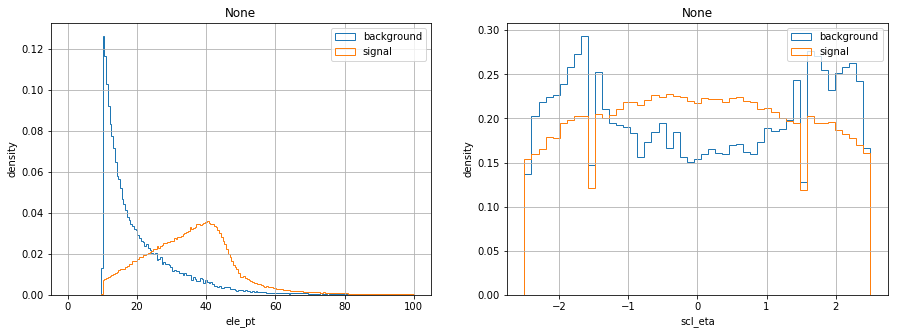

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df, "ele_pt", np.linspace(0, 100, 200), ax=axes[0])
plot_electrons(df, "scl_eta", np.linspace(-2.5, 2.5, 50), ax=axes[1])
plt.show()

Seems reasonable! The true prompt electrons have the $p_T$ peak that you expect from Z boson decays, and the fakes have the expected exponential spectrum and are predominantly at high pseudorapidity.

It's also interesting to look at the distributions for the MVA input variables (also called "features"). The `ele_oldsigmaietaieta` for example represents the spread of the electromagnetic shower and is more peaked and has smaller values for true electrons.

Let's look at `ele_oldsigmaietaieta` separately for barrel and endcap:

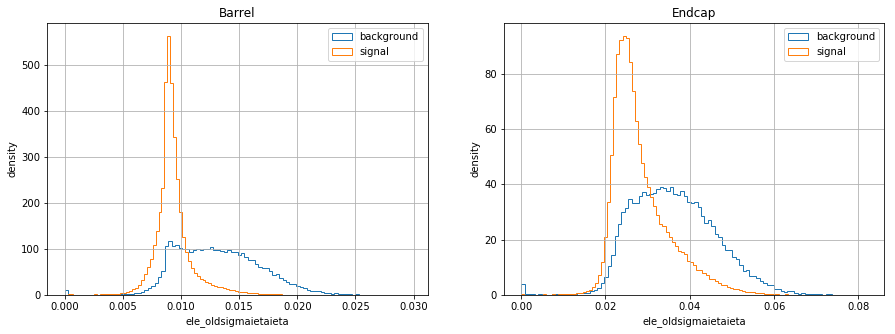

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", 100, ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", 100, ax=axes[1], title="Endcap")
plt.show()

Look at the X axis! The values are very different for barrel and endcap, which is the case also for other features. That's why we will have different trainings for barrel and endcap (also called EB and EE for Electronmagnetic Barrel/Endcap). In Run 2, we even split up the barrel in two different training regions (so 3 in total), because depending on the inner tracker the material budget is very different for the central Ecal barrel and the outer barrel. Naturally, the material budget influences the electron ID variables a lot.

At this point, feel free to look at other variables from the feature list below! Do you know what they represent? Unfortunately they are not explained in this tutorial, but there are many experts in CMS who are happy to explain them to you.

## Training the Boosted Decision Tree Classifiers

Let's write down a list with the the names of the features we will use. There are separate lists for EB and EE, because in the endcap we can use the fraction of the preshower energy as an additional feature. There is not preshower detector in the barrel.

In [16]:
features_barrel = ["ele_oldsigmaietaieta", "ele_oldsigmaiphiiphi",
            "ele_oldcircularity", "ele_oldr9", "ele_scletawidth",
            "ele_sclphiwidth", "ele_oldhe", "ele_kfhits", "ele_kfchi2",
            "ele_gsfchi2", "ele_fbrem", "ele_gsfhits",
            "ele_expected_inner_hits", "ele_conversionVertexFitProbability",
            "ele_ep", "ele_eelepout", "ele_IoEmIop", "ele_deltaetain",
            "ele_deltaphiin", "ele_deltaetaseed", "rho",
            "ele_pfPhotonIso", "ele_pfChargedHadIso", "ele_pfNeutralHadIso"]
            
features_endcap = features_barrel + ["ele_psEoverEraw"]

We got to import some more libraries now. Most importantly, we got to import __XGBooost__, to train gradient boosted decision trees. It is one of the three highly optimized libraries for this task, the others being [LightGBM](https://github.com/Microsoft/LightGBM) and [CatBoost](https://catboost.ai/). Feel free to try them out at some point, they should have a similar interface!

We also import the `train_test_split` function from __sklearn__ to shuffle and split the ntuple in a training and testing subset.

Lastly we import xgboost2tmva, which is included in this repository but was originally spotted [here](https://gist.github.com/andreh7/da90266301ac0204e054ab6f02fc6faa). It's meant to save the XGBoost models in the XML format used by TMVA, which is also the format we use in CMSSW for now.

In [17]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import xgboost2tmva

Next, we define the training parameters for XGBoost. Besides `n_boost_rounds`, there are a lot of hyperparameters that can be set, follow [this link](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) for a reference.

We don't change the defaults much. We just want to set `n_boost_rounds` to a relatively small value so the training does not take forever in a initial test run, set `eval_metric` to the Area Under the ROC Curver (AUC) and set the objective to binary classification. In a final training, you would rather set `n_boost_rounds` to a high number like 1000 and rely on early stopping to stop boosting when appropriate.

If you want, you can try out different hyperparameters later on! There are many resources on the internet about hyperparamter tuning for XGBoost.

In [18]:
n_boost_rounds = 10
xgboost_params = {'eval_metric':'auc',
                  #'max_depth' : 4,
                  'objective'  :'binary:logitraw'}

In Run 2, the MVA was trained in 6 categories. The splitting in three $|\eta|$ regions was already discussed before. Additionally, there are 3 separate trainings for $5 < p_T < 10$ GeV in Run 2. We define a list of category names to reasonably label the plots later. However, we will just do the trainings for $p_T$ > 10 GeV here.

In [19]:
category_titles = ["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]

Now this is where the train the BDTs. Please reade the inline comments for further explanations.

In [20]:
# The index of the training category (0 to 5) is stored in the "EleMVACats" column.
# We group the data frame by this column, which means in the loop we first have "group_df" where "EleMVACats" == 0, then 1, up to 5.
for i, group_df in df.groupby("EleMVACats"):
    
    # As said before, let's skip the low-pt trainings
    if i < 3:
        continue

    # get the category name
    category = category_titles[i]
    
    # get the features (either for endcap or barrel)
    features = features_endcap if "EE" in category else features_barrel
    
    # get the features and the target from the data frame
    X = group_df[features]
    y = group_df["matchedToGenEle"]

    # split X and y up in train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Fortunately we are dealing with pandas DataFrames here, so we can just get the indices correspondng to the testing and training samples.
    # This will come in handy when we want to figure out which rows in the original dataframe where used for trainingand testing.
    idx_train = X_train.index
    idx_test = X_test.index

    # XGBoost has it's own data format, so we have to create these structures.
    # The copies have no specific purpose other than silencing an xgboost warning.
    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))

    # Get the number of positive and nevative training examples in this category
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)

    print(category + ":")
    print("training on {0} signal and {1} background electrons".format(n_pos, n_neg))

    # There is one additional hyperparameter that we have to set per catoegy: `scale_pos_weight`.
    # It corresponds  to a weight given to every positive sample, and it usually set to
    # n_neg / n_pos when you have imbalanced datasets to balance the total contributions
    # of the positive and negative classes in the loss function
    xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos

    # In this line, we actually train the model.
    # Notice the `early_stopping_rounds`, which cause the boosting to automatically stop
    # when the test AUC has not decreased for 10 rounds. How does xgboost know what the training set is?
    # You pass it some dmatrices with labels as a list of tuples to the `evals` keyword argument.
    # The last entry in this list will be used for the early stopping criterion, in our case `dmatrix_test`.
    model = xgb.train(xgboost_params,
                      dmatrix_train,
                      num_boost_round=n_boost_rounds,
                      evals= [(dmatrix_train, 'train'),
                              (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    # We want to know if and when the training was early stopped.
    # `best_iteration` counts the first iteration as zero, so we increment by one.
    best_iteration = model.best_iteration + 1
    if best_iteration < n_boost_rounds:
        print("early stopping after {0} boosting rounds".format(best_iteration))
    print("")
    
    # Just in case we want to later implement the BDTs in CMSSW, we use the xgboost2tmva script
    # to save the model as a TMVA compatible XML file.
    # Note that the XML will not be pretty, as everything is printed in one line.
    # You can use the commandline tool `xmllint` with the `--format` option if you want to make it pretty.
    xgboost2tmva.convert_model(model.get_dump(),
                               input_variables=[(f,'F') for f in features],
                               output_xml='electron_id_{0}.xml'.format(i))
    
    # If we want to load the model again with the xgboost library, we can't use the XML file.
    # Hence, we also save the model in xgboosts own binary format just to be sure.
    model.save_model("electron_id_{0}.bin".format(i))

    # Now we see why it's good to have the indices corresponding to the train and test set!
    # We can now calculate classification scores with our freshly-trained model and store them
    # in a new column `score` of the original DataFrame at the appropriate places.
    df.loc[idx_train, "score"] = model.predict(dmatrix_train)
    df.loc[idx_test, "score"] = model.predict(dmatrix_test)
    
    # When we look at how the model performs later, we are mostly interested in the performance on the
    # test set. We can add another boolean column to indicate whether an electron is in the test set or not.
    df.loc[idx_train, "test"] = False
    df.loc[idx_test, "test"] = True

EB1_10:
training on 99639 signal and 10313 background electrons

EB2_10:
training on 79643 signal and 10307 background electrons

EE_10:
training on 101653 signal and 17875 background electrons



## ROC Curves

Time for some ROC curves! The sklearn library has a very useful function [`metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) which you pass the scores and the true labels, and it will return you:
* the false positive rate (`fpr`), also known as _background efficiency_
* the true positive rate (`tpr`), also known as _signal efficiency_
* the score thresholds corresponding to a given point on the curve, also known as _working point_
We define a little helper function to quickly plot ROC curves as we like to have them for the Electron MVA: with logarithmic y-axis and only showing signal efficiencies greater than 0.7.

In [21]:
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None, color=None, linestyle='-', label=None):
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df["matchedToGenEle"], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=label, color=color, linestyle=linestyle)

Finally we plot three different ROC curves in the 3 training categories:
1. The Run 2 MVA scores, which are stored in the ntuple in the `Fall17IsoV2RawVals` column
2. Our new training applied to the testing set
3. Our new training applied to the training se in order to check for overtraining.

__A note about overtraining__: Overtraining is not bad by itself! Usually you get the best performance on a test set for a model that is slightly overtrained. Too much overtraining however indicates that your model does not generalize well. You can more information on this topic if you research the "bias vs. variance tradeof" in machine learning.

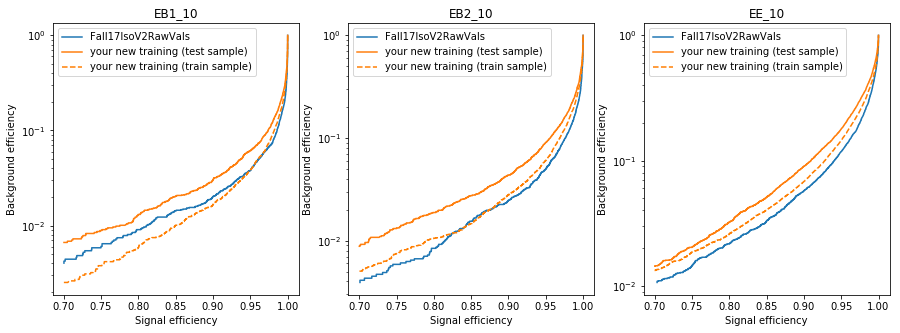

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, df_group in df.groupby("EleMVACats"):
    
    if i < 3:
        continue
    
    df_train = df_group.query("not test")
    df_test = df_group.query("test")
    
    ax = axes[i%3]
    plot_roc_curve(df_test, "Fall17IsoV2RawVals", ax=ax)
    plot_roc_curve(df_test, "score", ax=ax, label="your new training (test sample)")
    plot_roc_curve(df_train, "score", ax=ax, color="#ff7f02", linestyle='--', label="your new training (train sample)")
    ax.set_title(category_titles[i])
    ax.legend()
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    
plt.show()

We could train an identification algorithm on the new Run 3 DY+Jets samples which performs at the same order of magnitute as the Run 2 MVA, but not better.

This is a bit unexpected, as the Run 3 samples are different from the Run 2 samples in pileup, detector configuration and calibration. However, if you look at the [slides about the Run 2 training](https://rembserj.web.cern.ch/rembserj/slides/180321_egamma.pdf) (more precisely slide 6), you see that the previous training was done on millions of electrons, while we only had a few tens of thousands at hand. This illustrates that more often than not, "more data" can be the answer to your machine learning problems.

__Question:__ what  part of this notebook would you change to get out new training perform better?

## Determining Working Points

In this last step, we want to determine 80 and 90 % efficient working points in the 3 training categories. Usually, we want a tighter working point with 80 % signal efficiency  and a medium one woeh 90 % signal efficiency. We can find these working points by getting the appropriate quantiles of the score distribution in the signal class and compare them between the new training and the Run 2 training:

In [23]:
def get_working_points(df, score_column):
    
    working_points = {}

    for i, df_group in df.groupby("EleMVACats"):
        if i < 3:
            continue

        # get the category name
        category = category_titles[i]
        
        working_points[category] = {}

        df_test = df_group.query("test")
        signal_mask = df_test["matchedToGenEle"] == 1

        df_sig = df_test[signal_mask]
        df_bkg = df_test[~signal_mask]

        # Little detail here: as the signal efficiency has a significant turnon before pT around 20 GeV,
        # we tune the working point to have a given signal efficiency for pT > 20 GeV.
        wp80, wp90 = np.percentile(df_sig.query("ele_pt > 20")[score_column], [20., 10.])

        wp80_bkg_eff = 1.*len(df_bkg[df_bkg[score_column] >= wp80])/len(df_bkg)
        wp90_bkg_eff = 1.*len(df_bkg[df_bkg[score_column] >= wp90])/len(df_bkg)
        
        working_points[category]["wp80"] = wp80
        working_points[category]["wp90"] = wp90
        
        print("")
        print(category)
        print("bkg. efficiency at 80 % sig. eff: {0:.2f} %".format(wp90_bkg_eff * 100))
        print("bkg. efficiency at 90 % sig. eff: {0:.2f} %".format(wp80_bkg_eff * 100))
        
    return working_points

In [24]:
print("Finding working points for new training:")
working_points = get_working_points(df, "score")
print("")
print("Finding working points in the same way for Run 2 training:")
get_working_points(df, "Fall17IsoV2RawVals");

Finding working points for new training:

EB1_10
bkg. efficiency at 80 % sig. eff: 1.99 %
bkg. efficiency at 90 % sig. eff: 0.83 %

EB2_10
bkg. efficiency at 80 % sig. eff: 2.68 %
bkg. efficiency at 90 % sig. eff: 1.14 %

EE_10
bkg. efficiency at 80 % sig. eff: 6.30 %
bkg. efficiency at 90 % sig. eff: 2.14 %

Finding working points in the same way for Run 2 training:

EB1_10
bkg. efficiency at 80 % sig. eff: 1.29 %
bkg. efficiency at 90 % sig. eff: 0.48 %

EB2_10
bkg. efficiency at 80 % sig. eff: 1.55 %
bkg. efficiency at 90 % sig. eff: 0.49 %

EE_10
bkg. efficiency at 80 % sig. eff: 3.84 %
bkg. efficiency at 90 % sig. eff: 1.50 %


# Bonus: Differential Performance Studies

Usually, we also want to look at signal and background efficiencies differential in $p_T$, $\eta$ and pileup. We won't go into details here as time is running short, but you can find an example on how to produce turnon curves in $p_T$ relying on pandas `groupby` feature in the cell below:

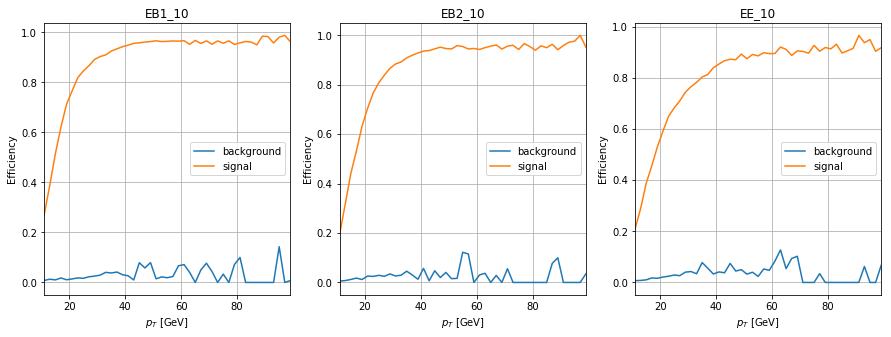

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

pt_bins = np.linspace(10, 100, 46)
pt_bin_centers = (pt_bins[:-1] + pt_bins[1:])/2.

bin_indices = np.digitize(df["ele_pt"], pt_bins) - 1
bin_indices[bin_indices == 45] = 44
df["pt_binned"] = pt_bin_centers[bin_indices]


def get_signal_efficiency(df, score_column, working_point):
    df_sig = df.query("matchedToGenEle == 1")
    return 1.*len(df_sig[df_sig[score_column] >= working_point])/len(df_sig)

def get_background_efficiency(df, score_column, working_point):
    df_bkg = df.query("matchedToGenEle == 0")
    return 1.*len(df_bkg[df_bkg[score_column] >= working_point])/len(df_bkg)

for i, df_group in df.groupby("EleMVACats"):
    
    if i < 3:
        continue
        
    wp80 = working_points[category]["wp80"]
    wp90 = working_points[category]["wp90"]

    ax = axes[i%3]
    df_group.groupby("pt_binned").apply(lambda df : get_background_efficiency(df, "score", wp80)).plot(label="background", ax=ax)
    df_group.groupby("pt_binned").apply(lambda df : get_signal_efficiency(df, "score", wp80)).plot(label="signal", ax=ax)
    ax.set_ylabel("Efficiency")
    ax.set_xlabel(r"$p_T$ [GeV]")
    ax.grid(True)
    ax.set_title(category_titles[i])
    ax.legend()
    
plt.show()

df = df.drop("pt_binned", axis=1)

We see the turn-on effect is actually very strong, even above $p_T$ > 20 GeV. This would get better with a larger training sample and more boosting rounds.